# Hierarchical Clustering Analysis - Omnibus Embedding

In [1]:
import string
from itertools import combinations_with_replacement

import graspologic as gp
import hyppo
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from hyppo.ksample import MANOVA, KSample
from pkg.data import (
    GENOTYPES,
    HEMISPHERES,
    SUB_STRUCTURES,
    SUPER_STRUCTURES,
    load_fa_corr,
    load_vertex_df,
    load_vertex_metadata,
    load_volume_corr,
)
from pkg.inference import run_ksample, run_pairwise
from pkg.plot import plot_heatmaps, plot_pairwise
from pkg.utils import binarize, squareize
from scipy.stats import kruskal
from seaborn.utils import relative_luminance
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.multitest import multipletests

matplotlib.rcParams["font.family"] = "monospace"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Load the data

volume_correlations, labels = load_volume_corr()

meta = load_vertex_df()

volume_correlations = binarize(volume_correlations)

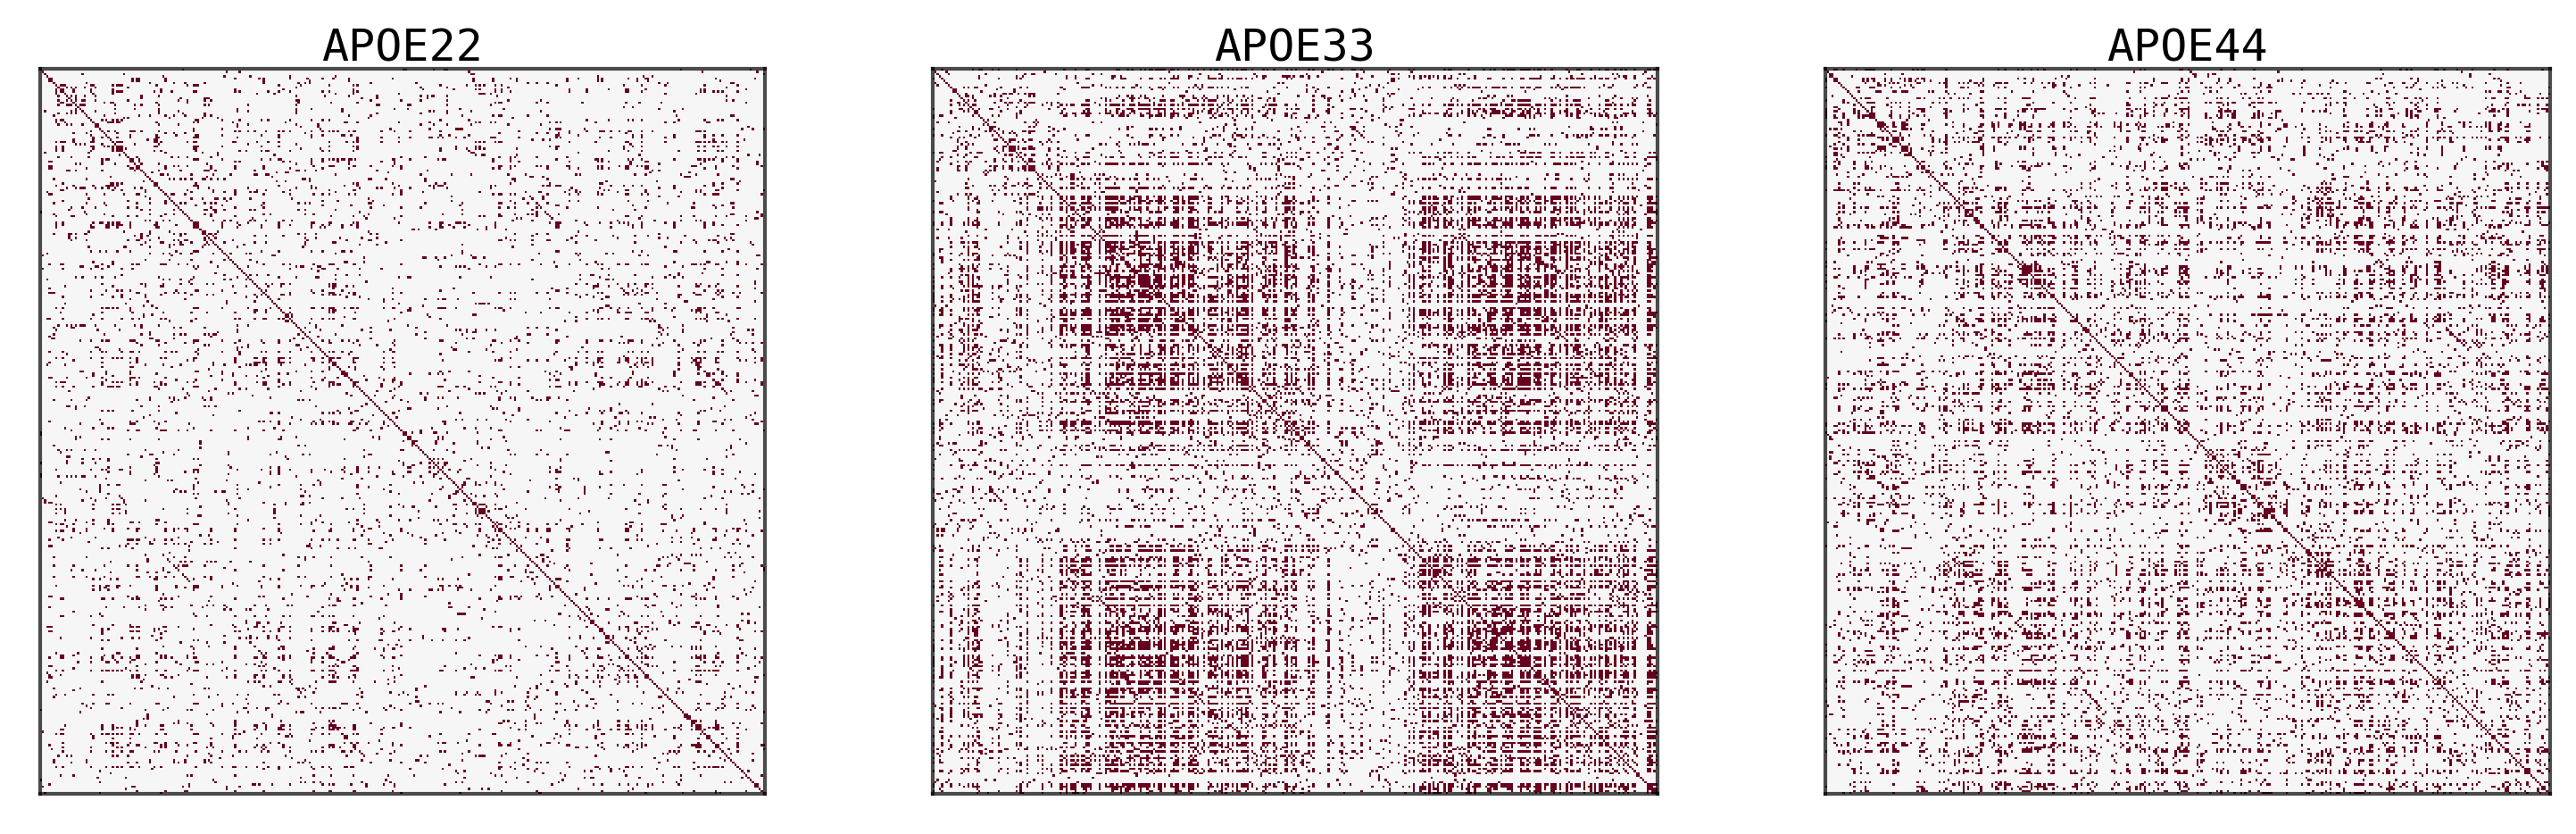

In [3]:
## Plot to make sure nothing is wrong
fig, ax = plt.subplots(
    ncols=3,
    figsize=(10, 3),
    constrained_layout=True,
    dpi=300,
    gridspec_kw=dict(width_ratios=[1, 1, 1]),
)

for i in range(len(volume_correlations)):
    gp.plot.adjplot(
        volume_correlations[i],
        ax=ax[i],
        vmin=-1,
        vmax=1,
        # meta=vertex_name,
        # group=["Hemisphere_abbrev"],
    )
    ax[i].set_title(f"{GENOTYPES[i]}", pad=0, size=12)

## Embed the data simultaneously using Multiple Adjacency Spectral Embedding (MASE)

The purpose of MASE is to obtain a low dimensional representation of the three correlation matrices such that the embedded correlation matrices can be compared to each other in a meaningful way {cite:p}`arroyo-mase`. Unlike omnibus embedding, MASE provides a common vertex representation across all correlation matrices. One can view this as a factoring out of common structures that are shared across all correlation matrices. This common representation of vertices provide a low dimensional vector per region of the brain, resulting in a $322\times d$ matrix per genotype where $d$ is the "embedding dimension" and $d << 332$. 

We will use the embeddings in order to perform hierchical clustering {cite:p}`athey2019autogmm,lyzinski2014perfect,priebe2019two`.

In [11]:
mase = gp.embed.MultipleASE(2)
Vhat = mase.fit_transform([corr for corr in volume_correlations])

Xhats = []

for score in mase.scores_:
    u, d, v = np.linalg.svd(score)
    Xhat = Vhat @ u @ np.diag(np.sqrt(d))

    Xhats.append(Xhat)

The automated algorithm chooses $d$ for us, which in this case is $d=4$.

## Perform hierarchical clustering

First we concatenate the embeddings resulting in a matrix with size $332 \times 3d$. We will iteratively divide the regions into two clusters. For example, we divide the $332$ regions into two clusters, and each resulting cluster will be divided into two more clusters, etc. The clustering algorithm used at each division is Gaussian mixture modeling {cite:p}`athey2019autogmm`.

The clustering algorithm will tell us which regions should be grouped together, and subsequently forms our "subgraphs" given by the clusterings. 

In [12]:
max_level = 4

cluster = gp.cluster.DivisiveCluster(
    max_level=max_level, cluster_kws={"kmeans_n_init": 5}
)

cluster_labels = cluster.fit_predict(Vhat, fcluster=True)

cluster_label_df = pd.DataFrame(
    cluster_labels, columns=[f"cluster_level_{i}" for i in range(1, max_level + 1)]
)

## Plotting the cluster labeling along with apriori labels using Sankey diagrams

Sankey diagrams tell us which regions or subregions belong to which clusters.

In [13]:
def count_groups(label_matrix):
    levels = label_matrix.shape[1] - 1
    d = []

    for level in range(levels):
        upper_cluster_ids = np.unique(label_matrix[:, level])

        for upper_cluster_id in upper_cluster_ids:
            lower_cluster_ids, counts = np.unique(
                label_matrix[label_matrix[:, level] == upper_cluster_id][:, level + 1],
                return_counts=True,
            )

            for idx, lower_cluster_id in enumerate(lower_cluster_ids):
                d.append((upper_cluster_id, lower_cluster_id, counts[idx]))

    d = np.array(d)

    source = d[:, 0]
    target = d[:, 1]
    value = d[:, 2]

    return source, target, value


def append_apriori_labels(apriori_labels, cluster_matrix):
    encoder = LabelEncoder()
    apriori_labels_encoded = encoder.fit_transform(apriori_labels)
    apriori_labels_encoded = apriori_labels_encoded.reshape(-1, 1)

    # Increase the original cluster_matrix labels
    cluster_matrix_ = cluster_matrix + np.max(apriori_labels_encoded) + 1

    out = np.hstack([apriori_labels_encoded, cluster_matrix_])

    return out, list(encoder.classes_)

In [14]:
hemispheric_clusters, encoded_labels = append_apriori_labels(
    meta.Hemisphere, cluster_labels
)

source, target, value = count_groups(hemispheric_clusters)

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=encoded_labels
                + [f"Cluster {i}" for i in range(np.max(hemispheric_clusters))],
            ),
            link=dict(source=source, target=target, value=value),
        )
    ]
)

fig.update_layout(title_text="Hemispheric Clustering", font_size=10)
fig.show(dpi=300, width=1000, height=600)

In [15]:
level_1_clusters, encoded_labels = append_apriori_labels(meta.Level_1, cluster_labels)

source, target, value = count_groups(level_1_clusters)

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=encoded_labels
                + [f"Cluster {i}" for i in range(np.max(level_1_clusters))],
            ),
            link=dict(source=source, target=target, value=value),
        )
    ]
)

fig.update_layout(title_text="Level 1 Clustering", font_size=10)
fig.show(dpi=300, width=1000, height=600)

## Visualizing different clustering levels using heatmaps

Heatmaps can qualitatively tell us if there are any underlying structures within the clusters.

In [16]:
cl = pd.DataFrame(
    cluster_labels, columns=[f"Cluster_{i}" for i in range(1, max_level + 1)]
)

meta = pd.concat([meta, cl], axis=1)

meta.head()

,Structure,Abbreviation,Hemisphere,Level_1,Level_2,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,Cingulate_Cortex_Area_24a,A24a,L,FB,IS,1,1,1,1,1,1,1,1
1,Cingulate_Cortex_Area_24a_prime,A24aPrime,L,FB,IS,0,3,5,5,0,2,4,4
2,Cingulate_Cortex_Area_24b,A24b,L,FB,IS,0,3,5,5,0,2,4,4
3,Cingulate_Cortex_Area_24b_prime,A24bPrime,L,FB,IS,0,3,4,6,0,3,7,7
4,Cingulate_Cortex_Area_29a,A29a,L,FB,IS,1,1,1,1,1,1,1,1


It seems like cluster structures are predominantly driven by the large correlations in the APOE3 genotype

## Testing for significantly different clusters at various levels

Again, the clusters tell us which regions should be grouped together. Hence, each cluster forms our subgraph. For each subgraph, we test whether the distribution of the latent positions (aka the embeddings) are significantly different. Specifically we test 

\begin{align}
H_0:& \qquad F_{APOE2}=F_{APOE3}=F_{APOE4}\\
H_A:& \qquad \text{At least one pair of distributions is different}
\end{align}

using a 3-sample distance correlation. We correct for multiple hypothesis testing via Holm-Bonferroni correction.

In [18]:
to_relabel = cl.astype(str)
relabels = {
    "0": "A1",
    "1": "A2",
}

for i in range(1, 5):
    if i == "1":
        col = to_relabel.loc[:, f"Cluster_{i}"]
        col.replace(relabels, inplace=True)
    elif i != "1":
        col = to_relabel.loc[:, f"Cluster_{i}"]
        uniques = np.unique(col)
        letter = string.ascii_uppercase[i - 1]
        for idx, u in enumerate(uniques):
            if u not in list(relabels.keys()):
                relabels[u] = letter + str(idx)
        col.replace(relabels, inplace=True)

l1 = to_relabel.Cluster_1
l2 = to_relabel.Cluster_1 + "-" + to_relabel.Cluster_2
l3 = to_relabel.Cluster_1 + "-" + to_relabel.Cluster_2 + "-" + to_relabel.Cluster_3
l4 = (
    to_relabel.Cluster_1
    + "-"
    + to_relabel.Cluster_2
    + "-"
    + to_relabel.Cluster_3
    + "-"
    + to_relabel.Cluster_4
)

In [19]:
volume_ksample = [
    run_ksample(volume_correlations, labels, idx, test="kruskal", absolute=True)
    for idx, labels in enumerate(
        [
            l1,
            l2,
            l3,
            l4,
        ]
    )
]

volume_ksample = pd.concat(volume_ksample, ignore_index=True)

volume_ksample.to_csv(
    "../results/outputs/mase_3sample_posteriori_binarized.csv", index=False
)

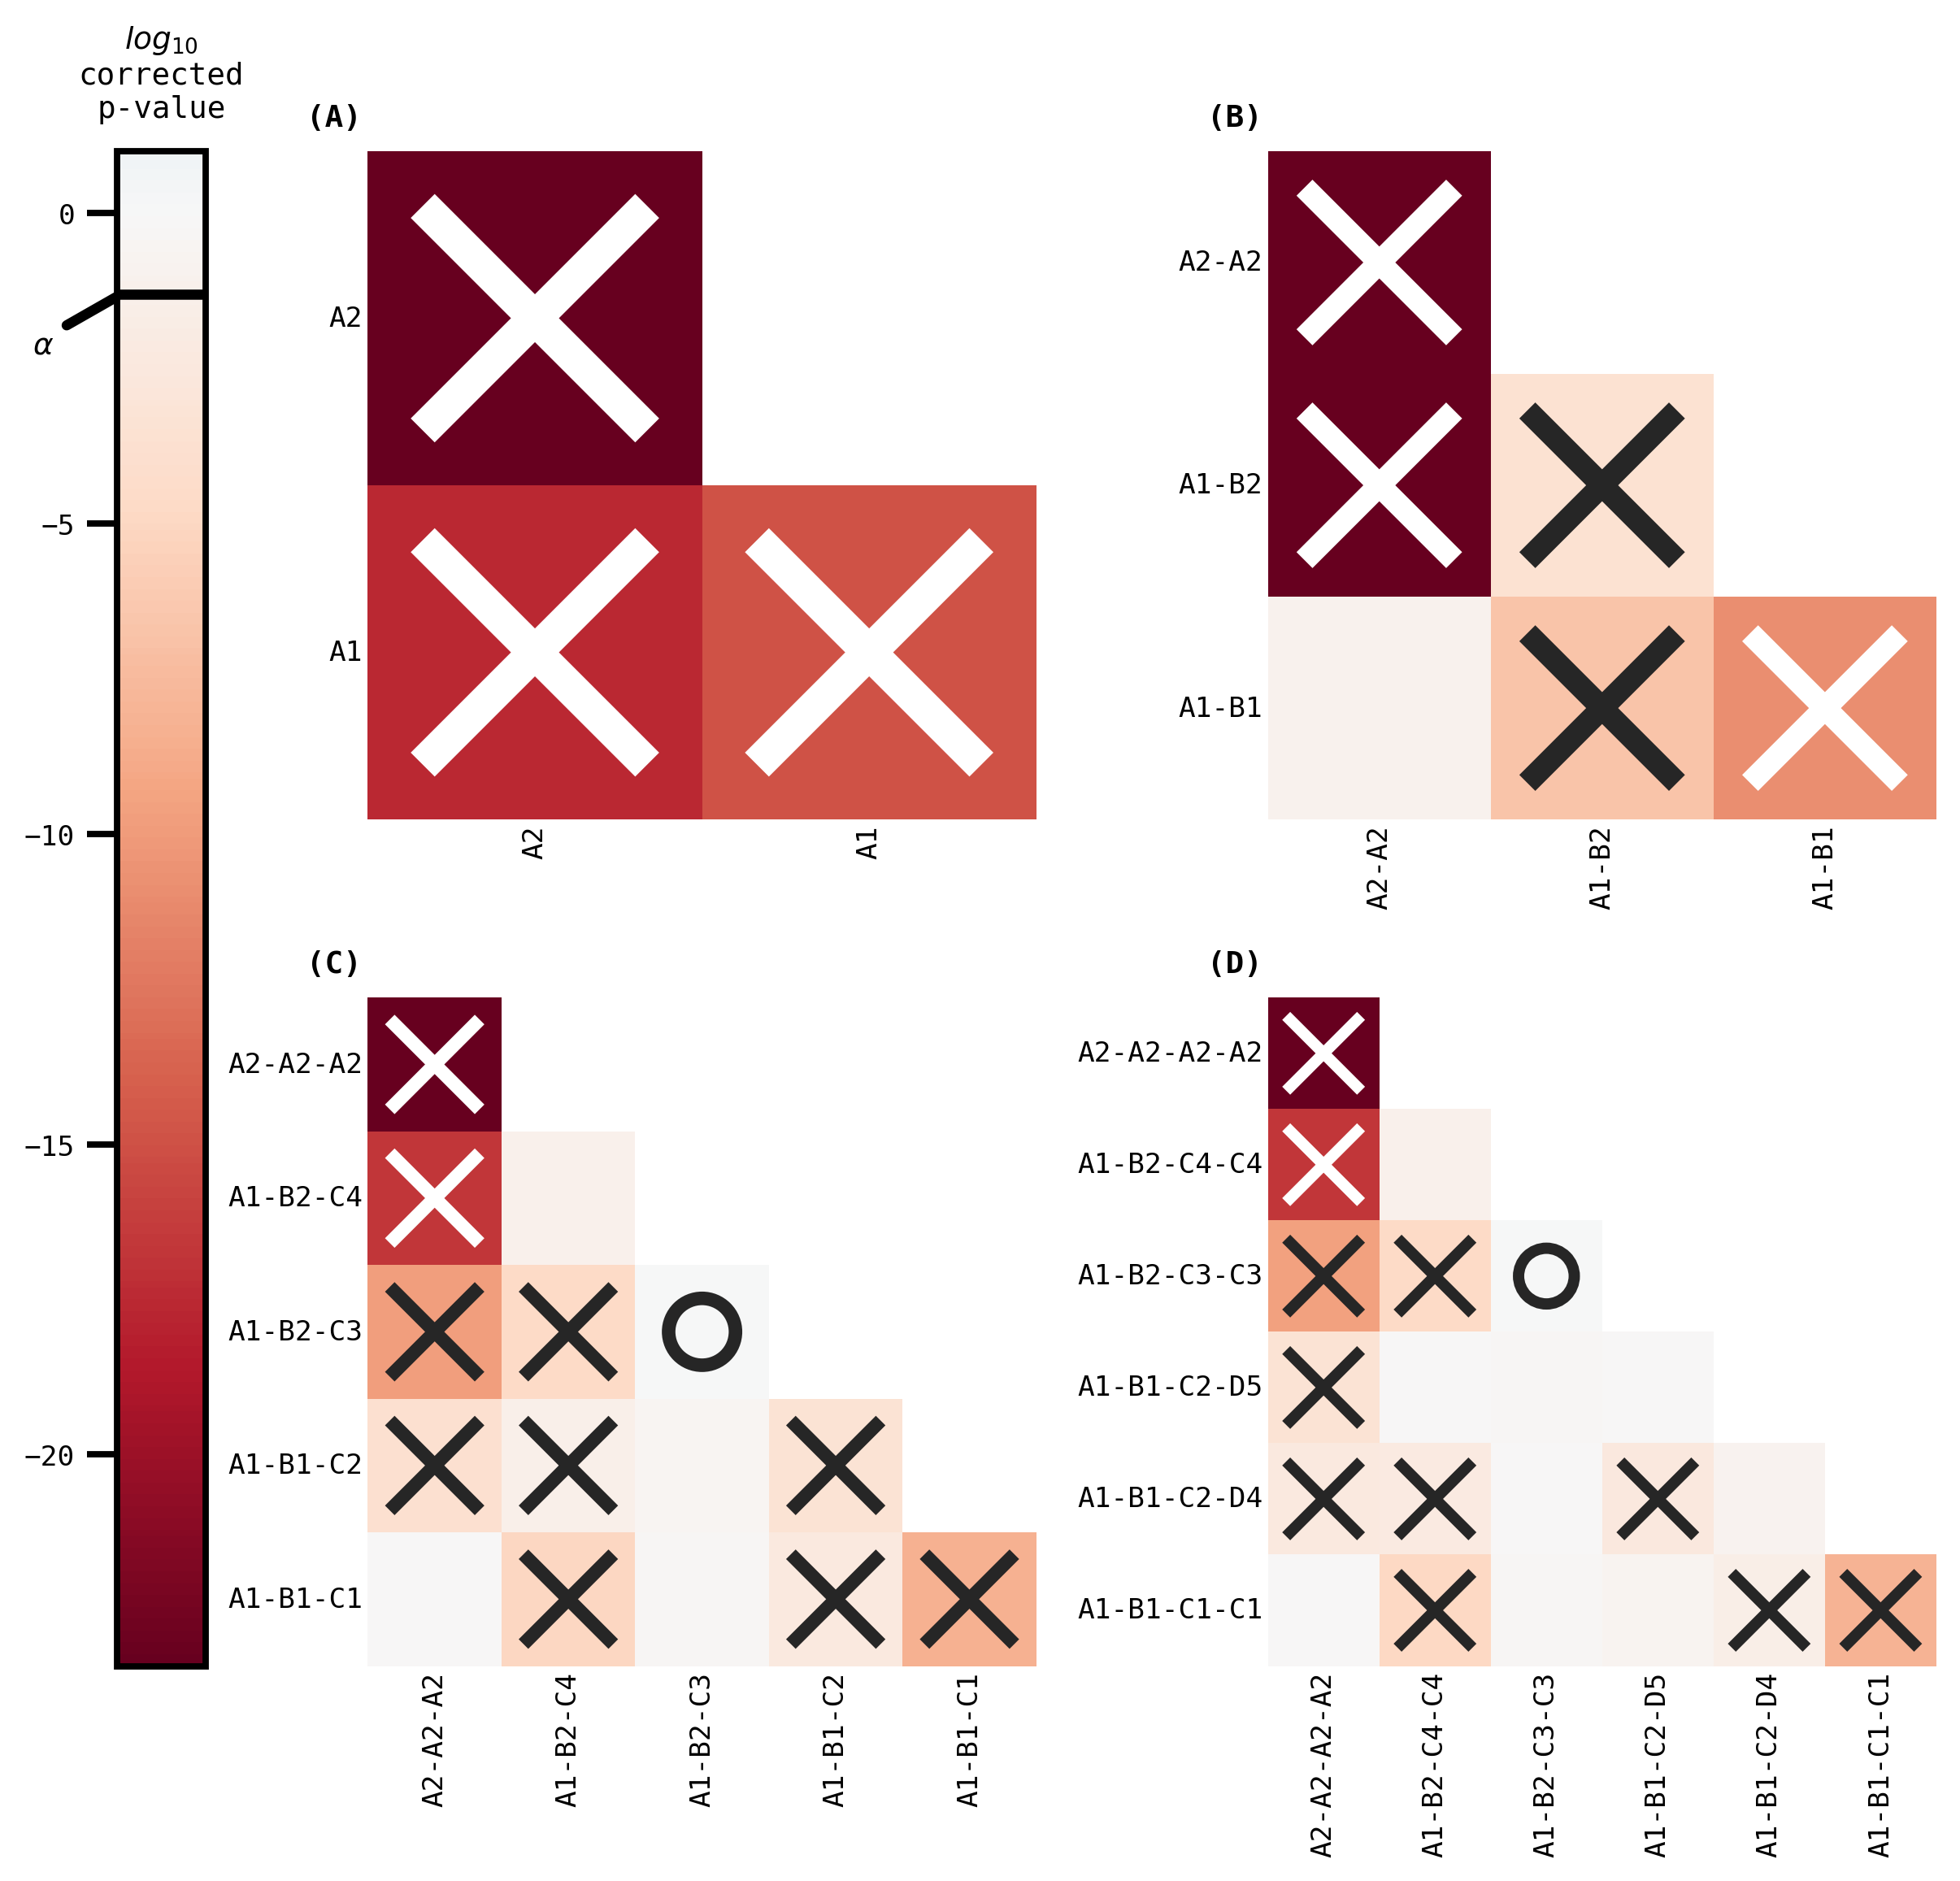

In [20]:
sns.set_context("talk", font_scale=0.5)
fig, _ = plot_heatmaps(volume_ksample, True)

fig.savefig("./figures/mase_ksample_volume_posteriori_binarized.pdf")

In [21]:
volume_pairwise = run_pairwise(
    volume_correlations,
    GENOTYPES,
    l4,
    absolute=True,
    test="mannwhitney",
)

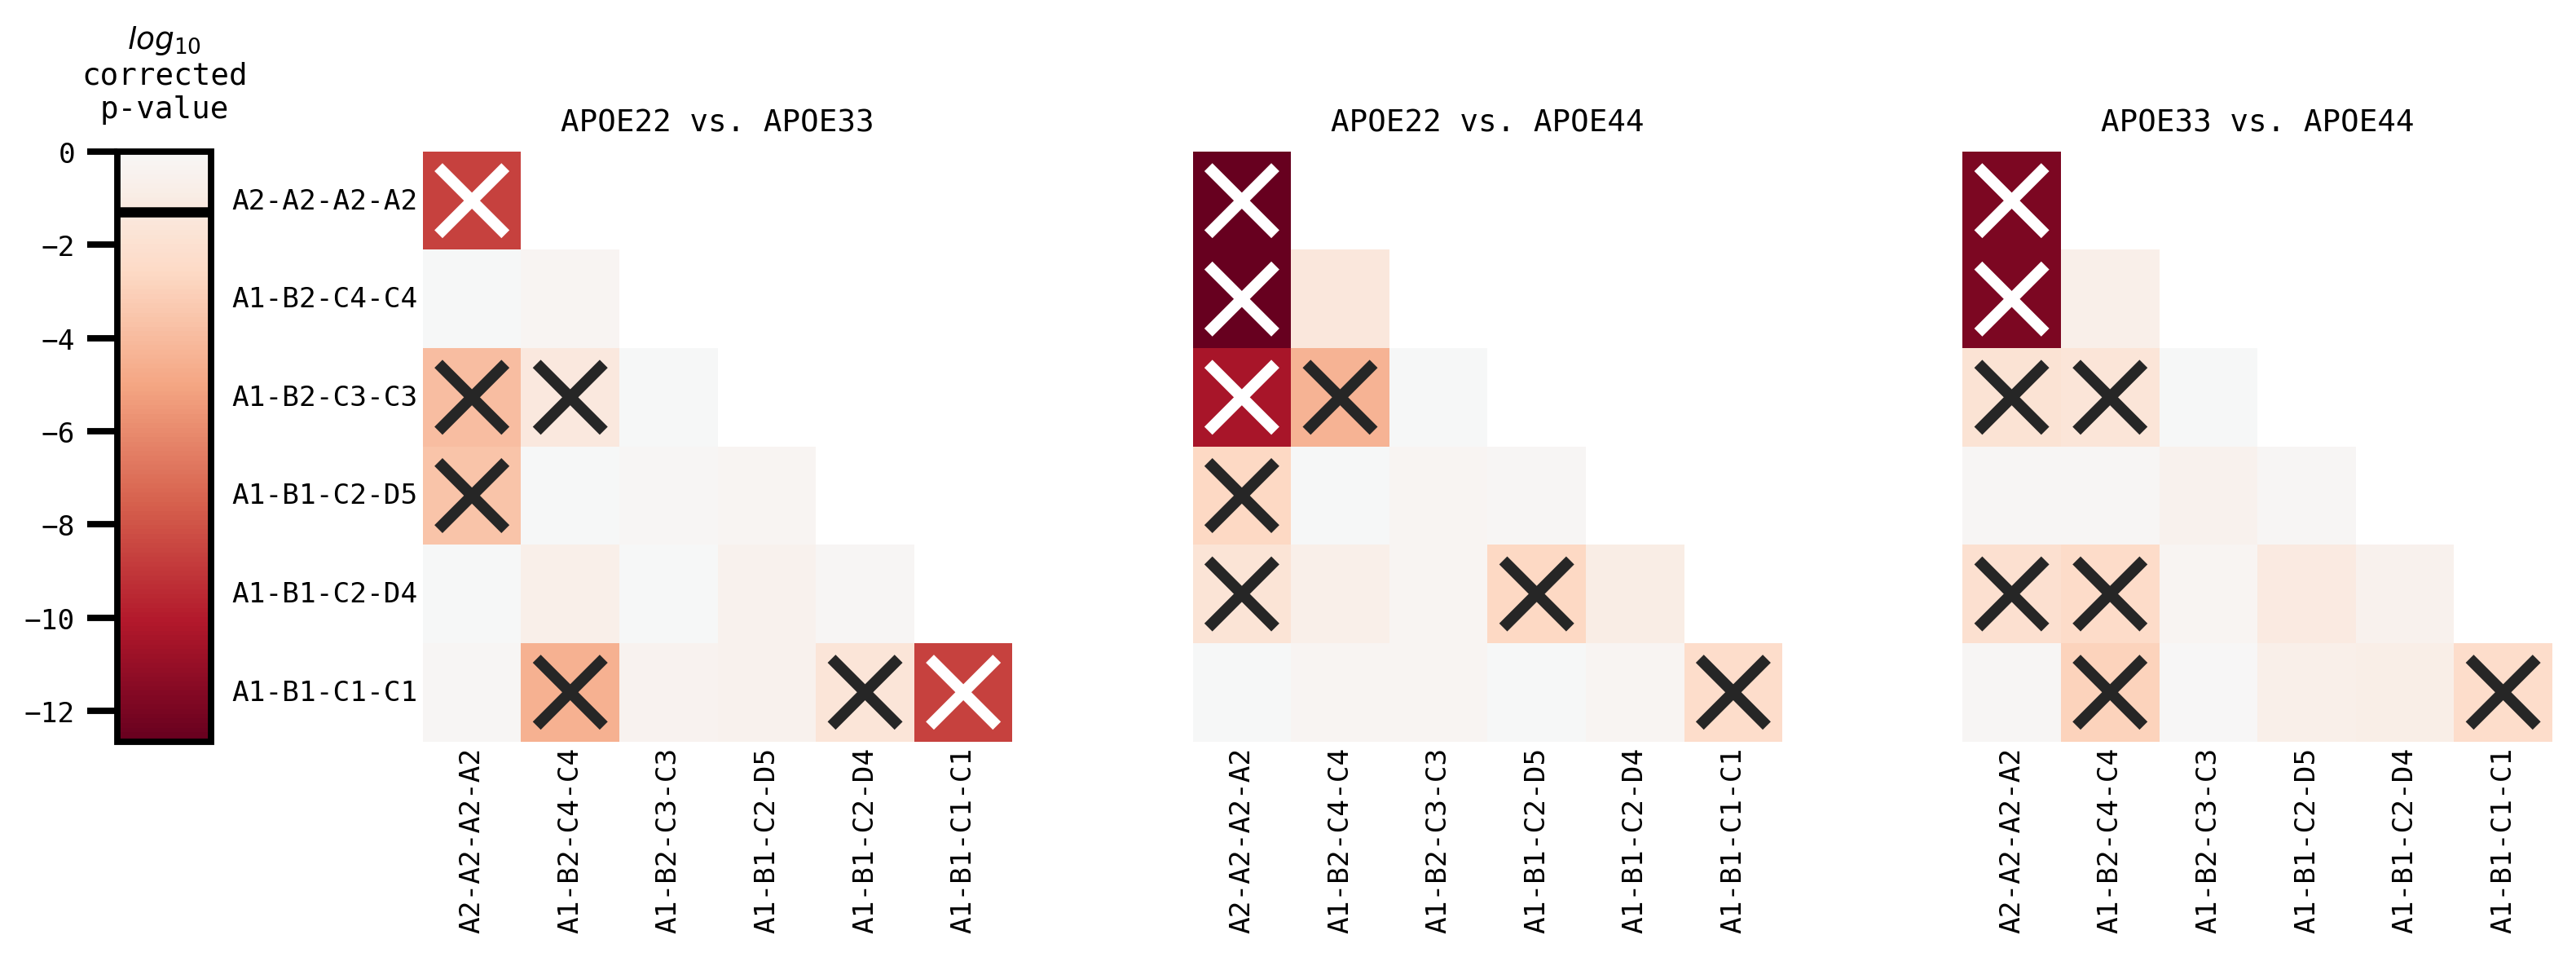

In [22]:
fig, _ = plot_pairwise(volume_pairwise, volume_ksample)
fig.savefig("./figures/mase_pairwise_volume_posteriori_binarized.pdf")